In [58]:
from train import *
from evaluation import *

BLOCK_SIZE = 16
NUM_BLOCK = 21
BLOCK_PER_IMAGE = NUM_BLOCK * NUM_BLOCK
OVERLAP = 4
SHAPE = (BLOCK_SIZE, BLOCK_SIZE, 3)
FILE_BATCH = 1
DATASET = 'celeba'

## Noise Image

In [98]:
test_files = sorted(glob.glob(cwd + 'celeba_test/' + '*'))
train = test_files[1:2]
clear_images = [load_celeb_images(train[i]) for i in range(FILE_BATCH)]
clear_images = np.concatenate(clear_images, axis=0)
test_images = np.array(clear_images)
noise_images = gen_noise(clear_images)

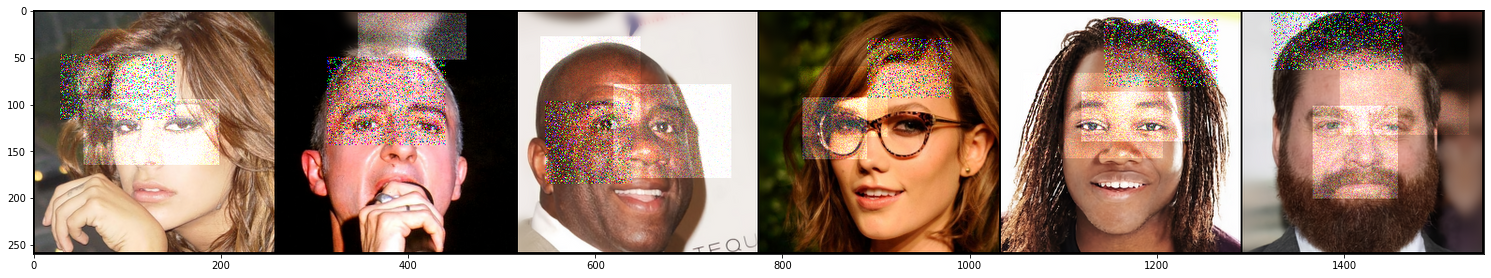

In [99]:
plot_image_grid(noise_images[6:12], 6)

## BM3D

In [42]:
!pip install bm3d
import bm3d

     |████████████████████████████████| 8.4MB 10.7MB/s 


In [81]:
bm3d_denoised_images = []
avg_psnr = 0
avg_ssim = 0
avg_uqi = 0
for i in range(len(test_images)):
    denoised_image = bm3d.bm3d(noise_images[i], sigma_psd=62, 
                              stage_arg=bm3d.BM3DStages.ALL_STAGES).astype('uint8')
    denoised_image = np.array(denoised_image)
    avg_psnr += cv2.PSNR(denoised_image, test_images[i])
    avg_ssim += ssim(denoised_image, test_images[i], multichannel=True)
    avg_uqi = sewar.full_ref.uqi(denoised_image, test_images[i], ws=8)
    bm3d_denoised_images.append(denoised_image)


print('***********************')
print('Results')
print('PSNR: ', avg_psnr/len(test_images))
print('SSIM: ', avg_ssim/len(test_images))
print('UQI: ', avg_uqi/len(test_images))
print('***********************')

***********************
Results
PSNR:  22.565679212207744
SSIM:  0.7588524948320551
UQI:  0.16485611302048778
***********************


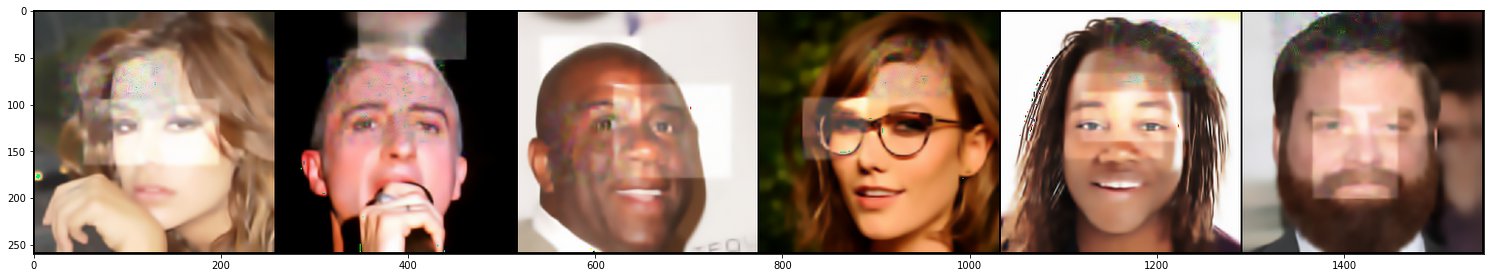

In [101]:
plot_image_grid(np.array(bm3d_denoised_images[6:12]), 6)

## Single Filter Results

In [102]:
clear_images, noise_images = gen_train_set(clear_images, noise_images, SHAPE,
                                           BLOCK_SIZE, NUM_BLOCK, OVERLAP)

In [84]:
single_encoder, single_decoder = load_models('pretrained models/' + DATASET + '_single_filter/')

In [103]:
avg_psnr, avg_ssim, avg_uqi = 0, 0, 0
z, z_mean, z_sig, y, y_logits, z_prior_mean, z_prior_sig = single_encoder.predict(noise_images)
            
recons_images_single = reconstruct_image(z, y, single_decoder, BLOCK_PER_IMAGE, WIDTH, 
                                  HEIGHT, BLOCK_SIZE, OVERLAP)
recons_images_single = tf.cast((recons_images_single*255), dtype=tf.uint8)

avg_psnr += quality_evaluation(recons_images_single, test_images, metric='PSNR')
avg_ssim += quality_evaluation(recons_images_single, test_images, metric='SSIM')
avg_uqi += quality_evaluation(recons_images_single, test_images, metric='UQI')
print('***********************')
print('Results')
print('PSNR: ', avg_psnr)
print('SSIM: ', avg_ssim)
print('UQI: ', avg_uqi)
print('***********************')

***********************
Results
PSNR:  26.671800903721305
SSIM:  0.7835816715249573
UQI:  0.9600099243775968
***********************


### Visualization

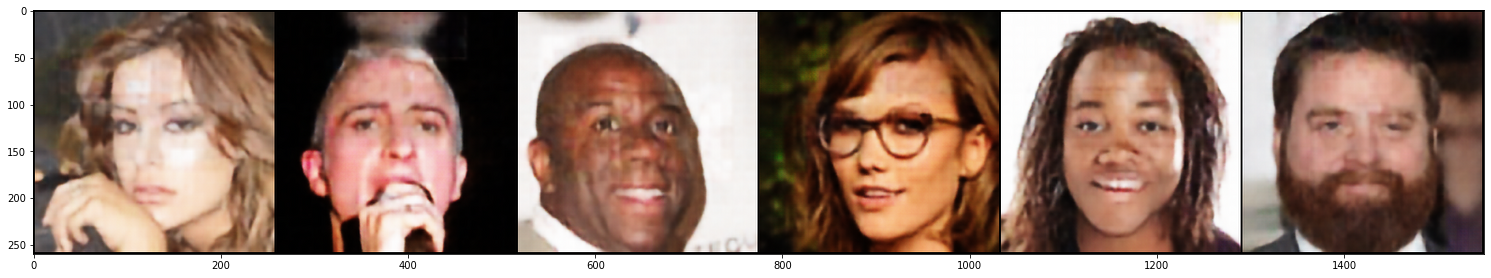

In [104]:
plot_image_grid(recons_images_single[6:12], 6)

## Multi-Filter Results

In [ ]:
encoder, decoders = load_models('pretrained models/' + DATASET + '_multi_filter/')

In [107]:
avg_psnr, avg_ssim, avg_uqi = 0, 0, 0

z, z_mean, z_sig, y, y_logits, z_prior_mean, z_prior_sig = encoder.predict(noise_images)
            
recons_images = reconstruct_image(z, y, decoders, BLOCK_PER_IMAGE, WIDTH, 
                                  HEIGHT, BLOCK_SIZE, OVERLAP)
recons_images = tf.cast((recons_images*255), dtype=tf.uint8)

avg_psnr += quality_evaluation(recons_images, test_images, metric='PSNR')
avg_ssim += quality_evaluation(recons_images, test_images, metric='SSIM')
avg_uqi += quality_evaluation(recons_images, test_images, metric='UQI')
print('***********************')
print('Overall Results')
print('PSNR: ', avg_psnr)
print('SSIM: ', avg_ssim)
print('UQI: ', avg_uqi)
print('***********************')

***********************
Overall Results
PSNR:  27.72599463363271
SSIM:  0.8097540058187214
UQI:  0.9677929083997745
***********************


### Visualization

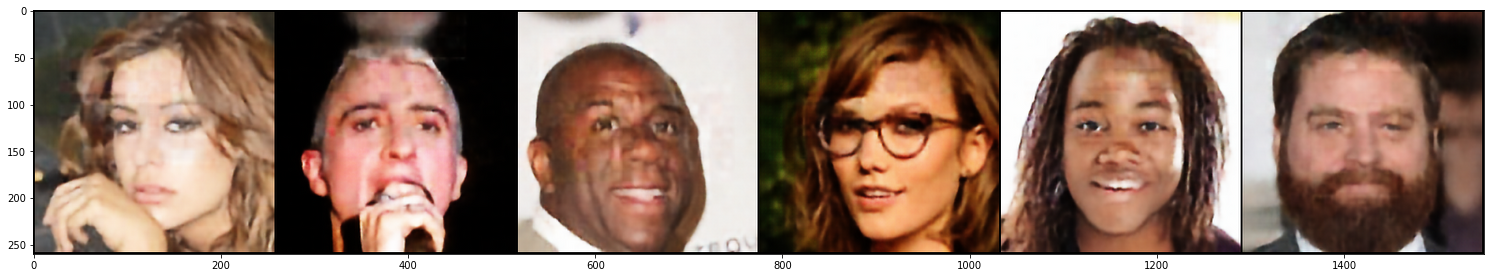

In [106]:
plot_image_grid(recons_images[6:12], 6)

## Comparison

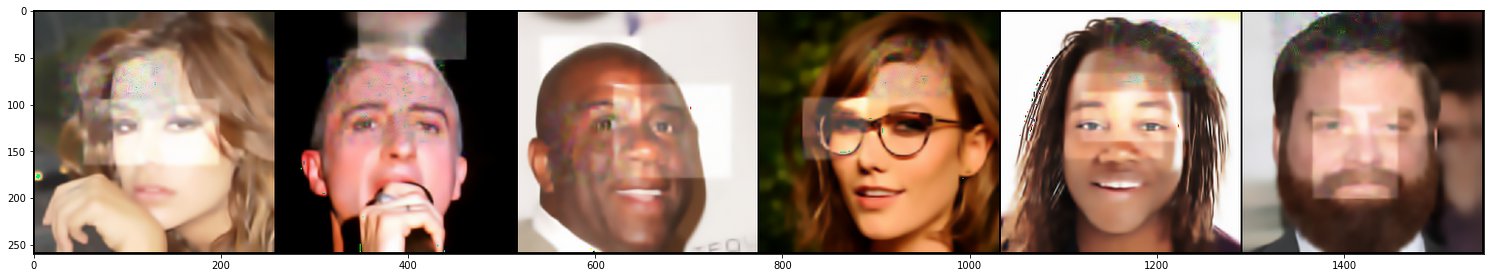

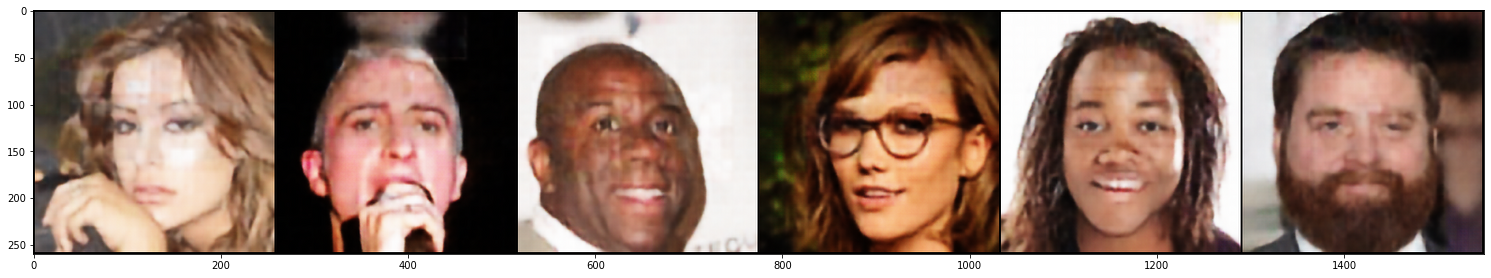

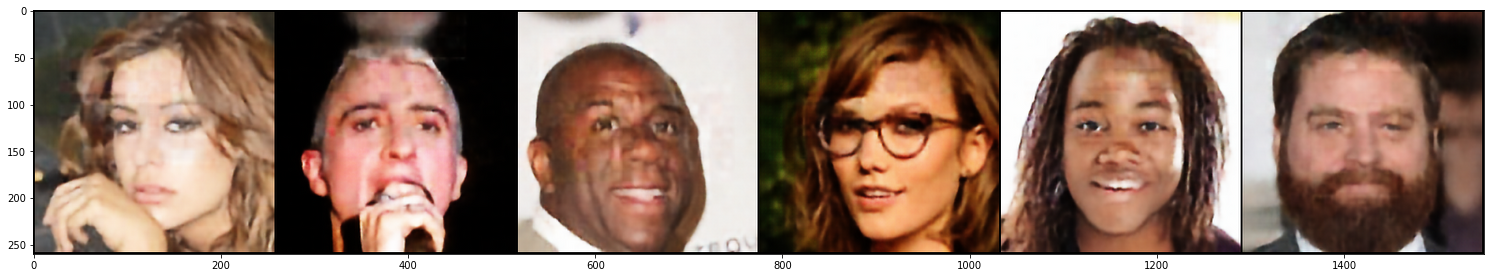

In [108]:
plot_image_grid(bm3d_denoised_images[6:12], 6)
plot_image_grid(recons_images_single[6:12], 6)
plot_image_grid(recons_images[6:12], 6)